In [1]:
import fecfile
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import us

Time the notebook

In [2]:
start = datetime.datetime.now()

Define logging function for writing output

In [3]:
def log(obj, description):
    print(description + ":")
    with open("../output/log.txt", "a") as f:
        f.write(f"{description}:\n\n{obj}\n\n---\n")
    return obj

Set some viewing options

In [4]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 500)

## Read data

Read dataframe of filings

In [5]:
filings = (
    pd.read_csv("../data/filings.csv")
)

filings.head(3)

,committee_id,filing_id,cycle,form_type,date_filed,date_coverage_to,date_coverage_from,report_title,report_period,fec_uri,paper,amended,amended_uri,is_amendment,original_filing,original_uri,committee_type,contributions_total,cash_on_hand,disbursements_total,receipts_total
0,C00401224,1190211,2016,F3,2017-11-03,2016-11-28,2016-10-20,POST-GENERAL,PG,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00401224/1190211/,False,False,NaN,True,1132265.0,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00401224/1132265/,W,69306148.22,24023158.64,70473625.32,70884967.84
1,C00401224,1167570,2016,F3,2017-06-27,2016-10-19,2016-10-01,PRE-GENERAL,PREG,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00401224/1167570/,False,False,NaN,True,1118321.0,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00401224/1118321/,W,38988748.30,23611816.12,36653226.26,41086481.96
2,C00401224,1166534,2016,F3,2017-06-19,2016-12-31,2016-11-29,YEAR-END,YE,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00401224/1166534/,False,False,NaN,True,1144458.0,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00401224/1144458/,W,14665549.11,24071137.23,15378810.13,15426788.72


Load candidates file

In [6]:
candidates = pd.read_csv(
    "../data/candidates.csv"
)

Read DataFrame of all ActBlue contributions

In [7]:
actblue = pd.read_csv(
    "../output/clean_actblue.csv",
    dtype = {
        "filing_id": "object",
        "contributor_organization_name": "object"
    },
    parse_dates = ['contribution_date']
)

actblue.head(3)

,entity_type,filer_committee_id_number,filing_id,transaction_id,contribution_date,contribution_amount,contribution_aggregate,contributor_organization_name,contributor_first_name,contributor_last_name,contributor_street_1,contributor_street_2,contributor_city,contributor_zip_code,contributor_state,contributor_employer,contributor_occupation,contribution_purpose_descrip,memo_text_description,donor_id,committee_id,actblue_committee_name,committee_name,candidate_name,latest_contribution_aggregate
0,IND,C00401224,1034155,SA11AI_28202360,2015-06-29,5.0,35.0,NaN,HOMA,A. HASHEMI,22 CLINTON AVE 9,NaN,STAMFORD,06901,CT,NOT EMPLOYED,NOT EMPLOYED,Earmark,Earmarked for DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE (C00000935),HOMA|A HASHEMI|06901,C00000935,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,35.0
1,IND,C00401224,1034155,SA11AI_28249728,2015-06-30,5.0,35.0,NaN,HOMA,A. HASHEMI,22 CLINTON AVE 9,NaN,STAMFORD,06901,CT,NOT EMPLOYED,NOT EMPLOYED,Earmark,Earmarked for DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE (C00000935),HOMA|A HASHEMI|06901,C00000935,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,35.0
2,IND,C00401224,1034155,SA11AI_28108486,2015-06-27,25.0,25.0,NaN,SHERI,A. OLSON,4008 SW ARROYO CT,NaN,SEATTLE,98146,WA,SELF,ARCHITECT,Earmark,Earmarked for DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE (C00000935),SHERI|A OLSON|98146,C00000935,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,25.0


Read ZIP Code Tabulation Area to county crosswalk from U.S. Census

In [8]:
zcta_census = (
    pd
    .read_csv(
        "../data/census/zcta_county.csv", 
        dtype = { 
            "ZCTA5": str, 
            "STATE": str,
            "GEOID": str
        }
    )
)

zcta_census.head()

,ZCTA5,STATE,COUNTY,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,COPOP,COHU,COAREA,COAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,COPOPPCT,COHUPCT,COAREAPCT,COAREALANDPCT
0,00601,72,1,72001,18465,7695,165132671,164333375,18570,7744,167459085,166659789,19483,8125,173777444,172725651,99.43,99.37,98.61,98.60,94.77,94.71,95.03,95.14
1,00601,72,141,72141,105,49,2326414,2326414,18570,7744,167459085,166659789,33149,14192,298027589,294039825,0.57,0.63,1.39,1.40,0.32,0.35,0.78,0.79
2,00602,72,3,72003,41520,18073,83734431,79288158,41520,18073,83734431,79288158,41959,18258,117948080,79904246,100.00,100.00,100.00,100.00,98.95,98.99,70.99,99.23
3,00603,72,5,72005,54689,25653,82063867,81880442,54689,25653,82063867,81880442,60949,28430,195741178,94608641,100.00,100.00,100.00,100.00,89.73,90.23,41.92,86.55
4,00606,72,93,72093,6276,2740,94864349,94851862,6615,2877,109592548,109580061,6276,2740,94864349,94851862,94.88,95.24,86.56,86.56,100.00,100.00,100.00,100.00


Some ZIP codes cross state boundaries. Find the main state, by population, associated with any given ZCTA

In [9]:
zcta_states = (
    zcta_census
    .groupby([ "ZCTA5", "STATE"])
    ["ZPOPPCT"]
    .sum()
    .reset_index()
    .sort_values("ZPOPPCT", ascending=False)
    .groupby("ZCTA5")
    ["STATE"]
    .first() # Get the top sorted state (largest)
    .apply(
        lambda x: us.states.lookup(x).name # get the name of the state
    )
    .to_frame("state")
    .reset_index()
    .rename(
        columns = { "ZCTA5": "contributor_zip_code"} # for easier merging later
    )
)

zcta_states.head()

,contributor_zip_code,state
0,00601,Puerto Rico
1,00602,Puerto Rico
2,00603,Puerto Rico
3,00606,Puerto Rico
4,00610,Puerto Rico


Build a DataFrame of contributors per ZIP

In [10]:
zip_donors = (
    actblue
    .groupby(
        ["candidate_name", 
         "contributor_zip_code"]
    )
    .size()
    .to_frame('contributors')
    .reset_index()
)

zip_donors.head(3)

,candidate_name,contributor_zip_code,contributors
0,21ST CENTURY DEMOCRATS,02155,1
1,21ST CENTURY DEMOCRATS,02446,1
2,21ST CENTURY DEMOCRATS,02809,2


There should be just one population figure per ZIP

In [11]:
assert (
    zcta_census
    .groupby('ZCTA5')
    ['ZPOP']
    .nunique()
    .max()
) == 1

In [12]:
# First get a lookup table of ZCTAs to Population figures 
zpop_lookup = (
    zcta_census
    .groupby('ZCTA5')
    ["ZPOP"].first()
    .reset_index()
)

Build at DataFrame of donors and donors per capita for each candidate-ZIP

In [13]:
# Calculate donors per 1000 population per zipcode
def calculate_per_capita(row):
    if row["zip_population"] == 0: return None
    return round(row["contributors"] * 1000.0 / float(row["zip_population"]), 1)

zip_totals = (
    zip_donors
    .merge(
        zcta_states,
        on = "contributor_zip_code",
        how = "left"
    )
    .merge( # merge back to census data to get the population
        zpop_lookup,
        left_on = "contributor_zip_code",
        right_on = "ZCTA5",
        how = "left"
    )
    .drop( columns = "ZCTA5" )
    .rename(
        columns = {"GEOID": "county_fip", "ZPOP": "zip_population"}
    )
    .assign(
        donors_per_1000_people = lambda frame: frame.apply(
            calculate_per_capita,
            axis = 1
        )
    )
)

zip_totals.head(3)

,candidate_name,contributor_zip_code,contributors,state,zip_population,donors_per_1000_people
0,21ST CENTURY DEMOCRATS,02155,1,Massachusetts,57964.0,0.0
1,21ST CENTURY DEMOCRATS,02446,1,Massachusetts,29311.0,0.0
2,21ST CENTURY DEMOCRATS,02809,2,Rhode Island,22938.0,0.1


In [14]:
# Doublecheck that we're not doubling up on ZIPS
assert(
    zip_totals
    .groupby(
        ['candidate_name','contributor_zip_code']
    )
    .count()
    ['contributors']
    .max()
) == 1

## Some sample insights

Donors per state

In [15]:
def get_total(row):
    return (
        zip_totals
        .loc[
            lambda x: x['candidate_name'] == row['candidate_name']
        ]
        ['contributors']
        .sum()
    )
state_totals = (
    zip_totals
    .groupby(
        ['candidate_name', 'state']
    ).pipe( lambda grp: pd.DataFrame({
        "contributors": grp['contributors'].sum(),
    }))
    .reset_index()
    .assign(
        total = lambda frame: frame.apply(get_total, axis = 1) 
    )
    .assign(
        percent = lambda frame: round(frame['contributors'] / frame['total'], 2)
    )
    .pivot(
        columns = "candidate_name",
        index = 'state',
        values = ['percent']
    )
    .droplevel(0, axis = 1)
)

In [16]:
## TODO: Percent of total NY and CA money makes for each candidate

Top ZIPs by donors per capita

In [17]:
def top_zips(candidate):
    return (
        zip_totals
        .loc[ lambda x: x["candidate_name"] == "BERNIE 2016" ]
        .sort_values(
            "contributors",
            ascending = False
        )
    )

top_zips("BERNIE 2016").head()

,candidate_name,contributor_zip_code,contributors,state,zip_population,donors_per_1000_people
5278,BERNIE 2016,05401,404,Vermont,28185.0,14.3
5369,BERNIE 2016,05602,168,Vermont,11916.0,14.1
5238,BERNIE 2016,05301,168,Vermont,16820.0,10.0
21638,BERNIE 2016,98103,148,Washington,45911.0,3.2
5291,BERNIE 2016,05403,138,Vermont,17593.0,7.8


In [18]:
# Convenience function to return a count of cities that are in a zip 
# (ZIPs can cross city boundaries as well as states)
def zip_to_cities(candidate, zipcode):
    return (
        actblue
        .loc[
            lambda x: x['candidate_name'] == candidate
        ]
        .loc[
            lambda x: x['contributor_zip_code'] == zipcode
        ]
        .groupby(['contributor_state', 'contributor_city'])
        .count()
        ['entity_type']
        .to_frame("contributors")
    )

zip_to_cities("BERNIE 2016", "95468")

,,contributors
contributor_state,contributor_city,
CA,POINT ARENA,10


Top zipcodes per capita, excluding Vermont

In [19]:
(
    zip_totals
    .loc[ lambda x: x["candidate_name"] == "BERNIE 2016" ]
    .loc[
        lambda x: (x["zip_population"] >= 1000) & (x["state"] != "Vermont")
    ]
    .sort_values(
        "donors_per_1000_people", 
        ascending = False
    ).head(3)
)

,candidate_name,contributor_zip_code,contributors,state,zip_population,donors_per_1000_people
18002,BERNIE 2016,81131,13,Colorado,1189.0,10.9
4042,BERNIE 2016,01330,15,Massachusetts,1506.0,10.0
4445,BERNIE 2016,02535,11,Massachusetts,1177.0,9.3


# Compare California

In [20]:
def compare_ca(candidates = ['21ST CENTURY DEMOCRATS','BERNIE 2016']):
    # get a lookup table of ca zips and population
    ca_zips = (
        zcta_census
        .loc[
            lambda x: x['STATE'] == "06"
        ]
        [["ZCTA5", "ZPOP"]]
        .rename( columns = {"ZCTA5": "contributor_zip_code"})
    )
    # get each candidates' donor totals per zip
    ca_candidates = (
        zip_totals
            .loc[
                lambda x: x['state'] == "California"
            ]
            .loc[
                lambda x: x['candidate_name'].isin(candidates)
            ]
            .groupby(['candidate_name','contributor_zip_code'])
            ['donors_per_1000_people']
            .first()
            .reset_index()
            .pivot(
                columns = 'candidate_name',
                index = 'contributor_zip_code',
                 values = 'donors_per_1000_people'
            )
        #     .droplevel(1, axis = 1)
            .reset_index() # make zip code it's own column for merging
    )
    
    return (
        ca_zips
        .merge(
            ca_candidates,
            on = 'contributor_zip_code'
        )
        .fillna(0)
        .sort_values('ZPOP', ascending = False)
    )

compare_ca().sort_values('BERNIE 2016', ascending = False)
    

,contributor_zip_code,ZPOP,21ST CENTURY DEMOCRATS,BERNIE 2016
57,90095,3,0.0,666.7
767,93943,6,0.0,166.7
1181,95486,62,0.0,32.3
988,94972,52,0.0,19.2
1271,95679,55,0.0,18.2
601,93042,56,0.0,17.9
726,93623,69,0.0,14.5
725,93623,69,0.0,14.5
340,92060,218,0.0,13.8
1219,95604,75,0.0,13.3


In [21]:
# Lookup zip
zip_to_cities('BERNIE 2016','90095')

,,contributors
contributor_state,contributor_city,
CA,LOS ANGELES,2


# Mapping

In [22]:
zcta_census

,ZCTA5,STATE,COUNTY,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,COPOP,COHU,COAREA,COAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,COPOPPCT,COHUPCT,COAREAPCT,COAREALANDPCT
0,00601,72,1,72001,18465,7695,165132671,164333375,18570,7744,167459085,166659789,19483,8125,173777444,172725651,99.43,99.37,98.61,98.60,94.77,94.71,95.03,95.14
1,00601,72,141,72141,105,49,2326414,2326414,18570,7744,167459085,166659789,33149,14192,298027589,294039825,0.57,0.63,1.39,1.40,0.32,0.35,0.78,0.79
2,00602,72,3,72003,41520,18073,83734431,79288158,41520,18073,83734431,79288158,41959,18258,117948080,79904246,100.00,100.00,100.00,100.00,98.95,98.99,70.99,99.23
3,00603,72,5,72005,54689,25653,82063867,81880442,54689,25653,82063867,81880442,60949,28430,195741178,94608641,100.00,100.00,100.00,100.00,89.73,90.23,41.92,86.55
4,00606,72,93,72093,6276,2740,94864349,94851862,6615,2877,109592548,109580061,6276,2740,94864349,94851862,94.88,95.24,86.56,86.56,100.00,100.00,100.00,100.00
5,00606,72,121,72121,89,38,6679806,6679806,6615,2877,109592548,109580061,25265,10958,92831653,92806330,1.35,1.32,6.10,6.10,0.35,0.35,7.20,7.20
6,00606,72,153,72153,250,99,8048393,8048393,6615,2877,109592548,109580061,42043,18020,178241098,176615594,3.78,3.44,7.34,7.34,0.59,0.55,4.52,4.56
7,00610,72,3,72003,160,62,237185,237185,29016,12618,97193468,93021467,41959,18258,117948080,79904246,0.55,0.49,0.24,0.25,0.38,0.34,0.20,0.30
8,00610,72,11,72011,28856,12556,96956283,92784282,29016,12618,97193468,93021467,29261,12755,116355489,101747783,99.45,99.51,99.76,99.75,98.62,98.44,83.33,91.19
9,00612,72,13,72013,66938,30961,183876062,174066899,67010,30992,184915406,175106243,96440,43253,443385518,326200544,99.89,99.90,99.44,99.41,69.41,71.58,41.47,53.36


In [23]:
# get a list of zips that are hard to visually map
unallowed_zips = (
    zcta_census.loc[ 
        lambda x: x['STATE'].str.contains("72|78|02|15") # Not in PR, VI, AK, 
    ]
    .rename(
        columns = {"ZCTA5": "ZCTA5CE10"}
    )
)

unallowed_zips.head()

,ZCTA5CE10,STATE,COUNTY,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,COPOP,COHU,COAREA,COAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,COPOPPCT,COHUPCT,COAREAPCT,COAREALANDPCT
0,00601,72,1,72001,18465,7695,165132671,164333375,18570,7744,167459085,166659789,19483,8125,173777444,172725651,99.43,99.37,98.61,98.60,94.77,94.71,95.03,95.14
1,00601,72,141,72141,105,49,2326414,2326414,18570,7744,167459085,166659789,33149,14192,298027589,294039825,0.57,0.63,1.39,1.40,0.32,0.35,0.78,0.79
2,00602,72,3,72003,41520,18073,83734431,79288158,41520,18073,83734431,79288158,41959,18258,117948080,79904246,100.00,100.00,100.00,100.00,98.95,98.99,70.99,99.23
3,00603,72,5,72005,54689,25653,82063867,81880442,54689,25653,82063867,81880442,60949,28430,195741178,94608641,100.00,100.00,100.00,100.00,89.73,90.23,41.92,86.55
4,00606,72,93,72093,6276,2740,94864349,94851862,6615,2877,109592548,109580061,6276,2740,94864349,94851862,94.88,95.24,86.56,86.56,100.00,100.00,100.00,100.00


Read ZCTA shapefile file and remove hard-to-map states

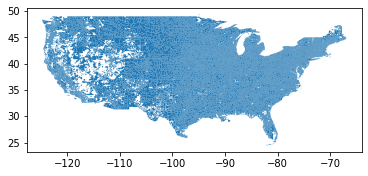

In [24]:
zctas = gpd.read_file(
    "../data/census/tl_2010_us_zcta510",
).loc[
    lambda x: ~x["ZCTA5CE10"].isin(unallowed_zips['ZCTA5CE10']) # not in PR, HI, AK
]

zctas.plot()

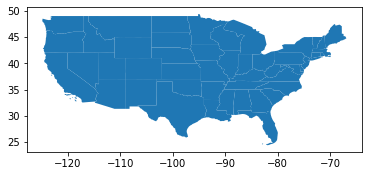

In [25]:
states = (
    gpd
    .read_file(
        "../data/census/tl_2018_us_state/"
    )
    .loc[
        lambda x: ~x['NAME'].str.contains("Virgin Islands|Mariana Islands|Guam|Alaska|Puerto Rico|Hawaii|Samoa")
    ]
)

states.plot()

In [26]:
def map_df(df, color, basemap = states):
    
    fig, ax = plt.subplots(figsize = (16, 9))
    
    if color[-1] == "s":
        options = {
            "cmap": color,
            "color": None,
            "column": "contributors",
            "ax": ax
        }
    else:
        options = {
            "cmap": None,
            "color": color,
            "column": "contributors",
            "ax": ax
        }

    ax = (
        basemap
        .plot(
            color = "gray",
            edgecolor = "white",
            linewidth = 0.5,
            ax = ax
        )
    )

    ax = (
        zctas
        .merge(
            df,
            left_on = "ZCTA5CE10",
            right_on = "contributor_zip_code"
        )
        .plot(
            **options
        )
    )

    ax.axis("off");
    
    
# Maps contributors and zipcodes for a candidate name
def map_donors(name, cutoff = 0, color = "Reds"):
    
    df = (
        zip_totals
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x['contributors'] > cutoff
        ]
    )
    
    map_df(df, color)
    
def donors_percapita(name, cutoff = 0, color = "Reds"):
    
    df = (
        zip_totals
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x["zip_population"] >= 1000
        ]
        .loc[
            lambda x: x['donors_per_1000_people'] > cutoff
        ]
    )
    
    map_df(df, color)

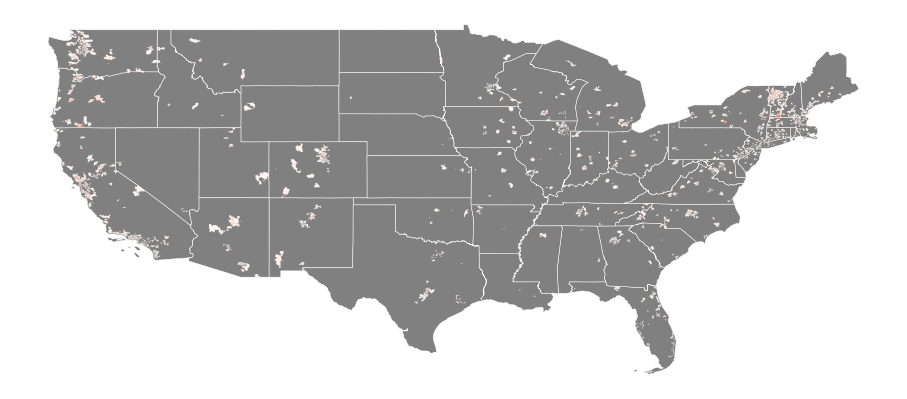

In [27]:
map_donors("BERNIE 2016", 10, "Reds")

In [28]:
# Maps contributors and zipcodes for a candidate name
def map_ca(name, cutoff = 0, color = "Reds"):
    
    # filter for name, cutoff and state
    df = (
        zip_totals
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x['contributors'] > cutoff
        ]
        .loc[
            lambda x: x['state'] == "California" 
        ]
    )
    
    # define basemap
    ca = (
        states
        .loc[
            lambda x: x['NAME'] == "California"
        ]
    )
    
    map_df(df, color, ca)
    
# Maps contributors and zipcodes for a candidate name
def map_ca_percapita(name, cutoff = 0, color = "Reds"):
    
    # filter for name, cutoff and state
    df = (
        zip_totals
        .loc[
            lambda x: x['state'] == "California" 
        ]
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x["zip_population"] >= 1000
        ]
        .loc[
            lambda x: x['donors_per_1000_people'] > cutoff
        ]

    )
    
    # define basemap
    ca = (
        states
        .loc[
            lambda x: x['NAME'] == "California"
        ]
    )
    
    map_df(df, color, ca)
    

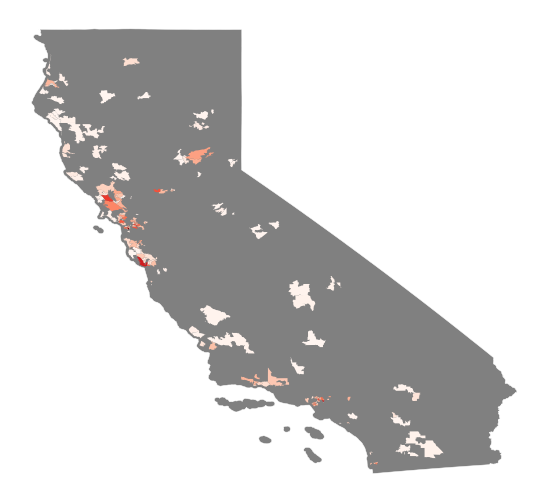

In [29]:
map_ca_percapita("BERNIE 2016", 1)

In [30]:
end = datetime.datetime.now()

d = (end - start)

f"The notebook ran for {round(d.total_seconds() / 60, 2) } minutes"

'The notebook ran for 1.29 minutes'

---

---

---